In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import os
from pathlib import Path
from PIL import Image
import random
from tqdm import tqdm, trange
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/BikeWayFinder/src/models'

/content/drive/MyDrive/BikeWayFinder/src/models


In [ ]:
#################################
## SET PATHS
#################################
cwd = Path(os.getcwd())
BASE_DIR = cwd.parent.parent
SURVEY_DIR = os.path.join(BASE_DIR, 'src', 'data', 'survey.csv')
REF_DIR = os.path.join(BASE_DIR, 'src', 'data', 'sampled_edges.csv')
IMAGE_DIR = os.path.join(BASE_DIR, 'src', 'data', 'survey_edges')

#################################
## DATA PREPROCESSING
#################################

df = pd.read_csv(SURVEY_DIR, sep=';')

# Define preprocessing function
def preprocess(data):
    # Remove participants who took less than 100 seconds to complete the survey
    data = data[data['duration'] > 100]
    # Remove irrelevant columns
    data = data.drop(data.columns[0:7], axis=1)
    data = data.drop(data.columns[819:], axis=1)
    # Replace all -77 with NaN
    data = data.replace(-77, np.nan)

    # Reshaping the data
    # Identify all v_66_... columns
    cols = [col for col in data.columns if col.startswith('v_66_')]
    data_list = []
    # Loop over each v_66_ column and calculate the means
    for col in cols:
        row = {
            'image': col,
            'mean': data[col].mean(),
            'stuttgart_yes': data[data['v_56'] == 1][col].mean(),
            'stuttgart_no': data[data['v_56'] == 2][col].mean(),
            'commute': data[data['v_67'] == 1][col].mean(),
            'recreation': data[data['v_67'] == 2][col].mean(),
            'equally': data[data['v_67'] == 3][col].mean(),
            'rarely': data[data['v_67'] == 4][col].mean()
        }
        data_list.append(row)

    # Create a DataFrame from the list of dictionaries
    data = pd.DataFrame(data_list)

    return data

df_new = preprocess(df)



#################################
## ADD SCORES TO EACH IMAGE
#################################

ref = pd.read_csv(REF_DIR, sep=';', header=None)
ref = ref.drop(ref.columns[3:8], axis=1)
ref.columns = ['cluster_num', 'survey_id', 'image_name']
ref['survey_id'] = ref['survey_id'].astype(str)

scores = df_new.drop(df_new.columns[2:8], axis=1)
scores['image'] = scores['image'].str.split('_').str[-1]

base_scores = pd.merge(ref, scores, left_on='survey_id', right_on='image', how='left')
base_scores = base_scores.drop('image', axis=1)

In [ ]:
#################################
## PARAMETER SETTINGS
#################################

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NUM_CLASSES = 1
LR = 1e-4  # Already trained model --> smaller learning rate
NUM_EPOCHS = 100

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]



#################################
## CREATING DATASETS & DATALOADERS
#################################

# Train, validation, test split
train_data, temp_test_data = train_test_split(base_scores, test_size=0.3, random_state=SEED)
valid_data, test_data = train_test_split(temp_test_data, test_size=2/3, random_state=SEED)

# Define dataset class
class SurveyDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 2])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx]['mean']

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the transformations
train_transform = transforms.Compose([transforms.Resize(size=IMG_SIZE),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.9,1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transform = transforms.Compose([transforms.Resize(size=IMG_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEAN, std=STD)
                                     ])

# Instantiate the datasets
train_dataset = SurveyDataset(data=train_data, img_dir=IMAGE_DIR, transform=train_transform)
valid_dataset = SurveyDataset(data=valid_data, img_dir=IMAGE_DIR, transform=test_transform)
test_dataset = SurveyDataset(data=test_data, img_dir=IMAGE_DIR, transform=test_transform)

# Instantiate the dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)



#################################
## LOAD PRETRAINED MODEL
#################################

model = resnet50(weights=ResNet50_Weights.DEFAULT)
print(model)

in_features = model.fc.in_features

# Redefine the final fully connected layer
final_fc = nn.Linear(in_features, NUM_CLASSES)
model.fc = final_fc
print(model.fc)

In [ ]:
#################################
## DEFINE TRAINING AND EVALUATION FUNCTIONS
#################################

# Training loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    for images, labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    return epoch_loss / len(loader)

# Evaluation loop
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0

    predictions = []
    actuals = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluation'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            epoch_loss += loss.item() * images.size(0)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()

    return epoch_loss / len(loader), predictions, actuals

# Function tracking epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# #################################
# ## TRAINING
# #################################

# optimizer = optim.Adam(model.parameters(), lr=LR)
# criterion = nn.MSELoss()

# criterion = criterion.to(DEVICE)
# model = model.to(DEVICE)

# # Training the model
# best_valid_loss = float('inf')

# training_loss = []
# validation_loss = []

# for epoch in trange(NUM_EPOCHS, desc="Epochs"):
#     start_time = time.monotonic()

#     train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
#     valid_loss, valid_predictions, valid_actuals = evaluate(model, valid_loader, criterion, DEVICE)

#     training_loss.append(train_loss)
#     validation_loss.append(valid_loss)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'survey_model.pt')

#     end_time = time.monotonic()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f}')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss().to(DEVICE)
model = model.to(DEVICE)

# Initialize the ReduceLROnPlateau learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

# Continue with the early stopping parameters
best_valid_loss = float('inf')
patience = 8
patience_counter = 0

training_loss = []
validation_loss = []

for epoch in trange(NUM_EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
    valid_loss, valid_predictions, valid_actuals = evaluate(model, valid_loader, criterion, DEVICE)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Scheduler step with validation loss for ReduceLROnPlateau
    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'survey_model.pt')
        patience_counter = 0
        print(f"Validation loss decreased to {valid_loss:.3f}, saving model")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | \tVal. Loss: {valid_loss:.3f}')

Training: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]

Epochs:   1%|          | 1/100 [00:13<21:56, 13.29s/it]

Validation loss decreased to 66.082, saving model
Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 156.578 | 	Val. Loss: 66.082



Training: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]

Epochs:   2%|▏         | 2/100 [00:26<21:55, 13.43s/it]

Validation loss decreased to 21.366, saving model
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 22.065 | 	Val. Loss: 21.366



Training: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]

Epochs:   3%|▎         | 3/100 [00:40<21:57, 13.58s/it]

Validation loss decreased to 12.622, saving model
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 12.321 | 	Val. Loss: 12.622



Training: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]

Epochs:   4%|▍         | 4/100 [00:55<22:26, 14.02s/it]

Validation loss decreased to 10.741, saving model
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 8.748 | 	Val. Loss: 10.741



Training: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]

Epochs:   5%|▌         | 5/100 [01:08<21:56, 13.85s/it]

Validation loss decreased to 9.515, saving model
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 7.569 | 	Val. Loss: 9.515



Training: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s]

Epochs:   6%|▌         | 6/100 [01:22<21:38, 13.81s/it]

Validation loss decreased to 9.464, saving model
Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 6.801 | 	Val. Loss: 9.464



Training: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s]

Epochs:   7%|▋         | 7/100 [01:36<21:19, 13.76s/it]

Validation loss decreased to 9.251, saving model
Epoch: 07 | Epoch Time: 0m 13s
	Train Loss: 5.675 | 	Val. Loss: 9.251



Training: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]

Epochs:   8%|▊         | 8/100 [01:49<20:48, 13.57s/it]

Patience counter: 1
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 4.885 | 	Val. Loss: 10.721



Training: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s]

Epochs:   9%|▉         | 9/100 [02:02<20:21, 13.42s/it]

Validation loss decreased to 8.846, saving model
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 4.224 | 	Val. Loss: 8.846



Training: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]

Epochs:  10%|█         | 10/100 [02:15<20:02, 13.36s/it]

Patience counter: 1
Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 4.583 | 	Val. Loss: 9.759



Training: 100%|██████████| 18/18 [00:12<00:00,  1.50it/s]

Epochs:  11%|█         | 11/100 [02:28<19:37, 13.23s/it]

Patience counter: 2
Epoch: 11 | Epoch Time: 0m 12s
	Train Loss: 4.900 | 	Val. Loss: 11.060



Training: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]

Epochs:  12%|█▏        | 12/100 [02:42<19:48, 13.50s/it]

Validation loss decreased to 8.409, saving model
Epoch: 12 | Epoch Time: 0m 14s
	Train Loss: 3.130 | 	Val. Loss: 8.409



Training: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]

Epochs:  13%|█▎        | 13/100 [02:56<19:30, 13.46s/it]

Patience counter: 1
Epoch: 13 | Epoch Time: 0m 13s
	Train Loss: 3.880 | 	Val. Loss: 9.164



Training: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]

Epochs:  14%|█▍        | 14/100 [03:09<19:10, 13.38s/it]

Validation loss decreased to 7.792, saving model
Epoch: 14 | Epoch Time: 0m 13s
	Train Loss: 3.399 | 	Val. Loss: 7.792



Training: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]

Epochs:  15%|█▌        | 15/100 [03:22<18:55, 13.36s/it]

Patience counter: 1
Epoch: 15 | Epoch Time: 0m 13s
	Train Loss: 3.068 | 	Val. Loss: 7.978



Training: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]

Epochs:  16%|█▌        | 16/100 [03:35<18:37, 13.30s/it]

Validation loss decreased to 7.031, saving model
Epoch: 16 | Epoch Time: 0m 13s
	Train Loss: 3.117 | 	Val. Loss: 7.031



Training: 100%|██████████| 18/18 [00:12<00:00,  1.48it/s]

Epochs:  17%|█▋        | 17/100 [03:49<18:33, 13.42s/it]

Validation loss decreased to 6.811, saving model
Epoch: 17 | Epoch Time: 0m 13s
	Train Loss: 2.950 | 	Val. Loss: 6.811



Training: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]

Epochs:  18%|█▊        | 18/100 [04:02<18:14, 13.34s/it]

Patience counter: 1
Epoch: 18 | Epoch Time: 0m 13s
	Train Loss: 2.955 | 	Val. Loss: 6.826



Training: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]

Epochs:  19%|█▉        | 19/100 [04:15<17:49, 13.21s/it]

Patience counter: 2
Epoch: 19 | Epoch Time: 0m 12s
	Train Loss: 2.423 | 	Val. Loss: 7.304



Training: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]

Epochs:  20%|██        | 20/100 [04:28<17:25, 13.07s/it]

Patience counter: 3
Epoch: 20 | Epoch Time: 0m 12s
	Train Loss: 2.771 | 	Val. Loss: 6.931



Training: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]

Epochs:  21%|██        | 21/100 [04:41<17:08, 13.01s/it]

Patience counter: 4
Epoch: 21 | Epoch Time: 0m 12s
	Train Loss: 1.916 | 	Val. Loss: 7.493



Training: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]

Epochs:  22%|██▏       | 22/100 [04:54<16:51, 12.97s/it]

Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Patience counter: 5
Epoch: 22 | Epoch Time: 0m 12s
	Train Loss: 2.261 | 	Val. Loss: 7.119



Training: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]

Epochs:  23%|██▎       | 23/100 [05:06<16:38, 12.96s/it]

Patience counter: 6
Epoch: 23 | Epoch Time: 0m 12s
	Train Loss: 1.837 | 	Val. Loss: 6.913



Training: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]

Epochs:  24%|██▍       | 24/100 [05:19<16:25, 12.97s/it]

Patience counter: 7
Epoch: 24 | Epoch Time: 0m 12s
	Train Loss: 2.118 | 	Val. Loss: 6.813



Training: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]

Epochs:  24%|██▍       | 24/100 [05:32<17:34, 13.87s/it]

Patience counter: 8
Early stopping triggered


In [ ]:
best_valid_loss

6.810555259386699

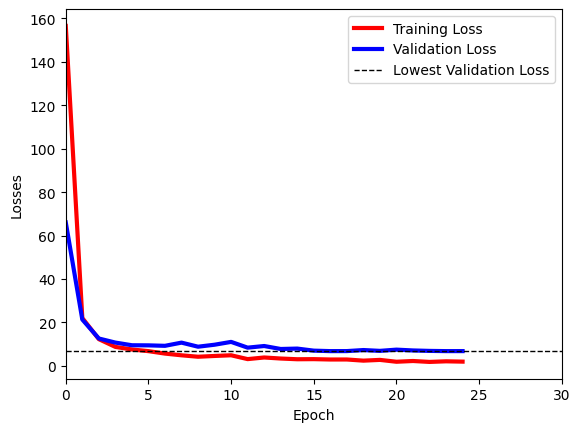

In [ ]:
# plot training and validation loss
plt.plot(training_loss, c='red', lw=3, label='Training Loss')
plt.plot(validation_loss, c='blue', lw=3, label='Validation Loss')
plt.axhline(y=best_valid_loss, c='black', lw=1, ls='--', label='Lowest Validation Loss')
plt.xlabel('Epoch');
plt.ylabel('Losses');
plt.xlim((0, 30));
plt.legend(loc='best')

In [ ]:
model.load_state_dict(torch.load('survey_model.pt'))
model.to(DEVICE)

# Testing on unseen data
test_loss, test_predictions, test_actuals = evaluate(model, test_loader, criterion, DEVICE)

print(f'\t Test Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

	 Test Loss: 9.737


In [ ]:
temp = pd.DataFrame({
    'Predicted': test_predictions,
    'Actual': test_actuals
})

temp

,Predicted,Actual
0,4.159715,4.421053
1,2.855626,2.529412
2,2.973913,3.000000
3,4.242284,3.611111
4,2.947539,2.437500
...,...,...
159,3.289066,3.450000
160,3.520911,3.157895
161,2.903930,2.903226
162,3.286153,3.818182


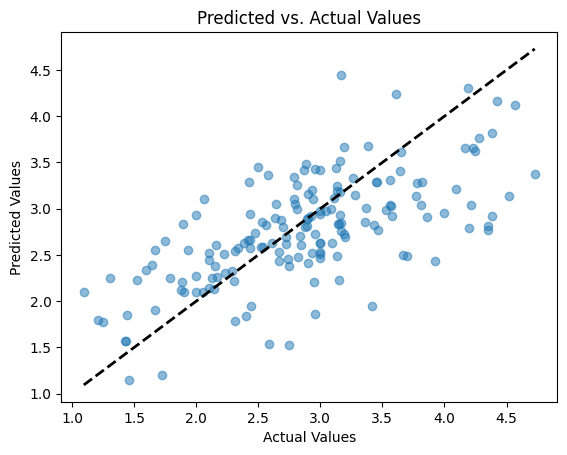

In [ ]:
# Checking quality of predictions
plt.scatter(temp['Actual'], temp['Predicted'], alpha=0.5)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([temp['Actual'].min(), temp['Actual'].max()], [temp['Actual'].min(), temp['Actual'].max()], 'k--', lw=2)
plt.show()

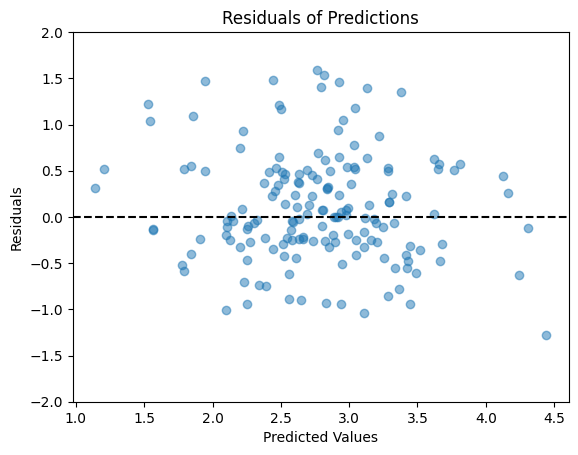

In [ ]:
residuals = temp['Actual'] - temp['Predicted']

plt.scatter(temp['Predicted'], residuals, alpha=0.5)
plt.title('Residuals of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.ylim((-2, 2))
plt.show()

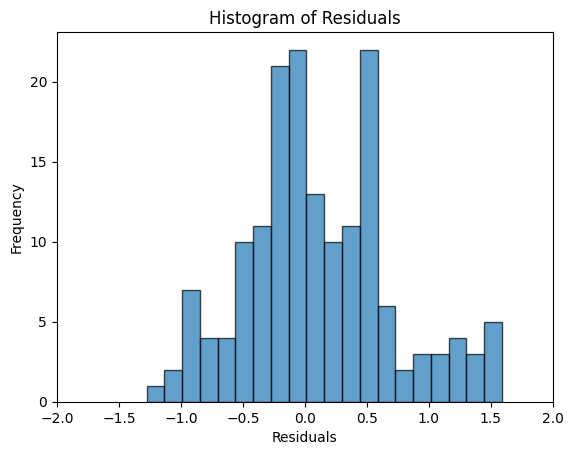

In [ ]:
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xlim((-2, 2))
plt.show()

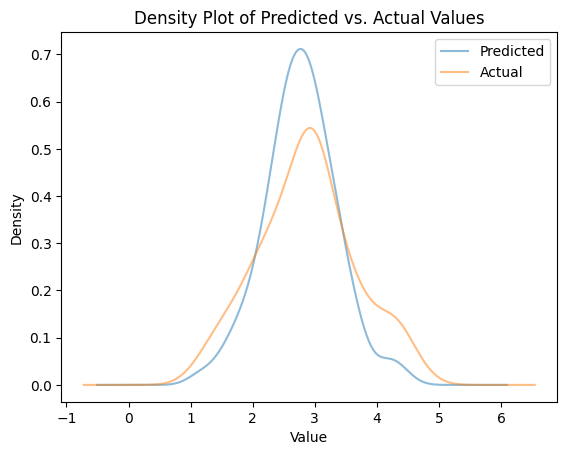

In [ ]:
temp['Predicted'].plot(kind='density', label='Predicted', alpha=0.5)
temp['Actual'].plot(kind='density', label='Actual', alpha=0.5)
plt.title('Density Plot of Predicted vs. Actual Values')
plt.xlabel('Value')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(temp['Actual'], temp['Predicted'])
rmse = mse ** 0.5
mae = mean_absolute_error(temp['Actual'], temp['Predicted'])

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

MSE: 0.36, RMSE: 0.60, MAE: 0.46


In [ ]:
#################################
## CALCULATING SCORES FOR UNSEEN DATA
#################################

# Unseen data dir
UNSEEN_DIR = os.path.join(BASE_DIR, 'src', 'data', 'edges')

# Define dataset class
class UnseenDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # List all image files in the img_dir
        self.image_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

# Define the transformations
unseen_transform = transforms.Compose([transforms.Resize(size=IMG_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=MEAN, std=STD)
                                       ])

# Instantiate the datasets
unseen_dataset = UnseenDataset(img_dir=UNSEEN_DIR, transform=unseen_transform)
loader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features
final_fc = nn.Linear(in_features, NUM_CLASSES)
model.fc = final_fc

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.9MB/s]


In [ ]:
# Load saved model
model.load_state_dict(torch.load('survey_model.pt'))
model.to(DEVICE)

# Use model to predict scores on unseen data
model.eval()

predictions = []
filenames = []

with torch.no_grad():
    for images, files in tqdm(loader, desc='Predicting'):
        images = images.to(DEVICE)
        outputs = model(images)
        predictions.extend(outputs.cpu().numpy())
        filenames.extend(files)

Predicting: 100%|██████████| 186/186 [03:04<00:00,  1.01it/s]


In [ ]:
results = pd.DataFrame({
    'Filename': filenames,
    'Prediction': [pred[0] for pred in predictions]
})
results

,Filename,Prediction
0,edges-cluster_10885.jpg,2.789274
1,edges-cluster_10893.jpg,2.476346
2,edges-cluster_10894.jpg,2.637502
3,edges-cluster_10895.jpg,2.887349
4,edges-cluster_10907.jpg,2.874584
...,...,...
5916,edges-cluster_1380.jpg,2.252657
5917,edges-cluster_1385.jpg,2.440789
5918,edges-cluster_1386.jpg,2.702524
5919,edges-cluster_1384.jpg,2.485168


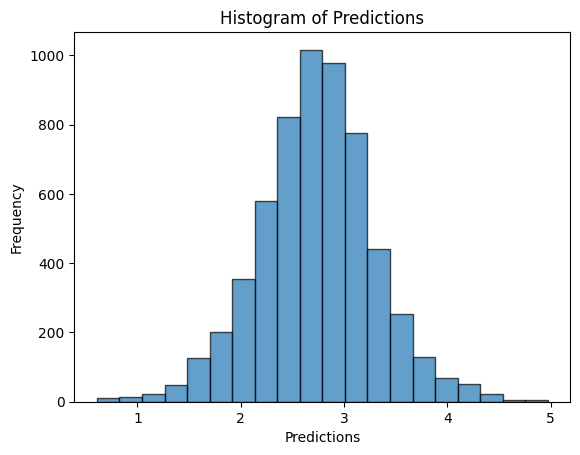

In [ ]:
# Histogram of the predictions
plt.hist(results['Prediction'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.show()

In [ ]:
results.to_csv('unseen_predictions.csv', index=False)

### New Edges Data

In [ ]:
NEW_DIR = os.path.join(BASE_DIR, 'data', 'new_edges')

In [ ]:
!unzip '/content/drive/MyDrive/BikeWayFinder/edges_svi_sorted.zip' -d '/content/drive/MyDrive/BikeWayFinder/data/new_edges'

In [ ]:
# Instantiate the datasets
new_dataset = UnseenDataset(img_dir=NEW_DIR, transform=unseen_transform)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features
final_fc = nn.Linear(in_features, NUM_CLASSES)
model.fc = final_fc

In [ ]:
# Load saved model
model.load_state_dict(torch.load('survey_model.pt'))
model.to(DEVICE)

# Use model to predict scores on unseen data
model.eval()

predictions_new = []
filenames_new = []

with torch.no_grad():
    for images, files in tqdm(new_loader, desc='Predicting'):
        images = images.to(DEVICE)
        outputs = model(images)
        predictions_new.extend(outputs.cpu().numpy())
        filenames_new.extend(files)

Predicting: 100%|██████████| 392/392 [02:29<00:00,  2.63it/s]


In [ ]:
results_new = pd.DataFrame({
    'Filename': filenames_new,
    'Prediction': [pred[0] for pred in predictions_new]
})
results_new

,Filename,Prediction
0,edges-cluster_0.jpg,2.503647
1,edges-cluster_1.jpg,2.711699
2,edges-cluster_10.jpg,2.182441
3,edges-cluster_100.jpg,2.433360
4,edges-cluster_1000.jpg,2.147246
...,...,...
12527,edges-cluster_9958.jpg,2.873021
12528,edges-cluster_998.jpg,2.193894
12529,edges-cluster_9986.jpg,2.775064
12530,edges-cluster_999.jpg,1.718314


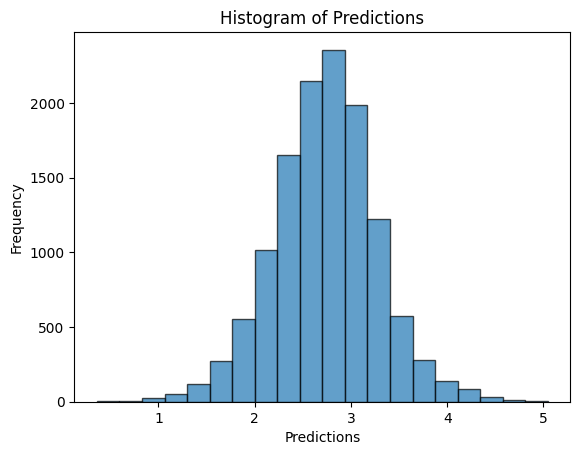

In [ ]:
# Histogram of the predictions
plt.hist(results_new['Prediction'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Rounding below 1 values to 1 and above 5 to 5
def custom_round(value):
    if value < 1:
        return 1
    elif value > 5:
        return 5
    else:
        return value

results_new['Prediction'] = results_new['Prediction'].apply(custom_round)

In [75]:
# Output directory
OUT_DIR = os.path.join(BASE_DIR, 'src', 'data', 'new_edges_predictions.csv')

results_new.to_csv(OUT_DIR, index=False)

### Sanity Checks

In [ ]:
filtered_rows = results_new[(results_new['Prediction'] == 1)]
image_filenames = filtered_rows['Filename']

In [ ]:
from PIL import Image
import math

images_per_row = 5

num_images = len(image_filenames)
num_rows = math.ceil(num_images / images_per_row)

# Set up the figure size and grid layout
plt.figure(figsize=(20, num_rows * 4))

for i, filename in enumerate(image_filenames, start=1):
    img_path = os.path.join(NEW_DIR, filename)
    image = Image.open(img_path)

    plt.subplot(num_rows, images_per_row, i)
    plt.imshow(image)
    plt.title(filename, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [71]:
filtered_rows = results_new[(results_new['Prediction'] > 4.8)]
image_filenames = filtered_rows['Filename']

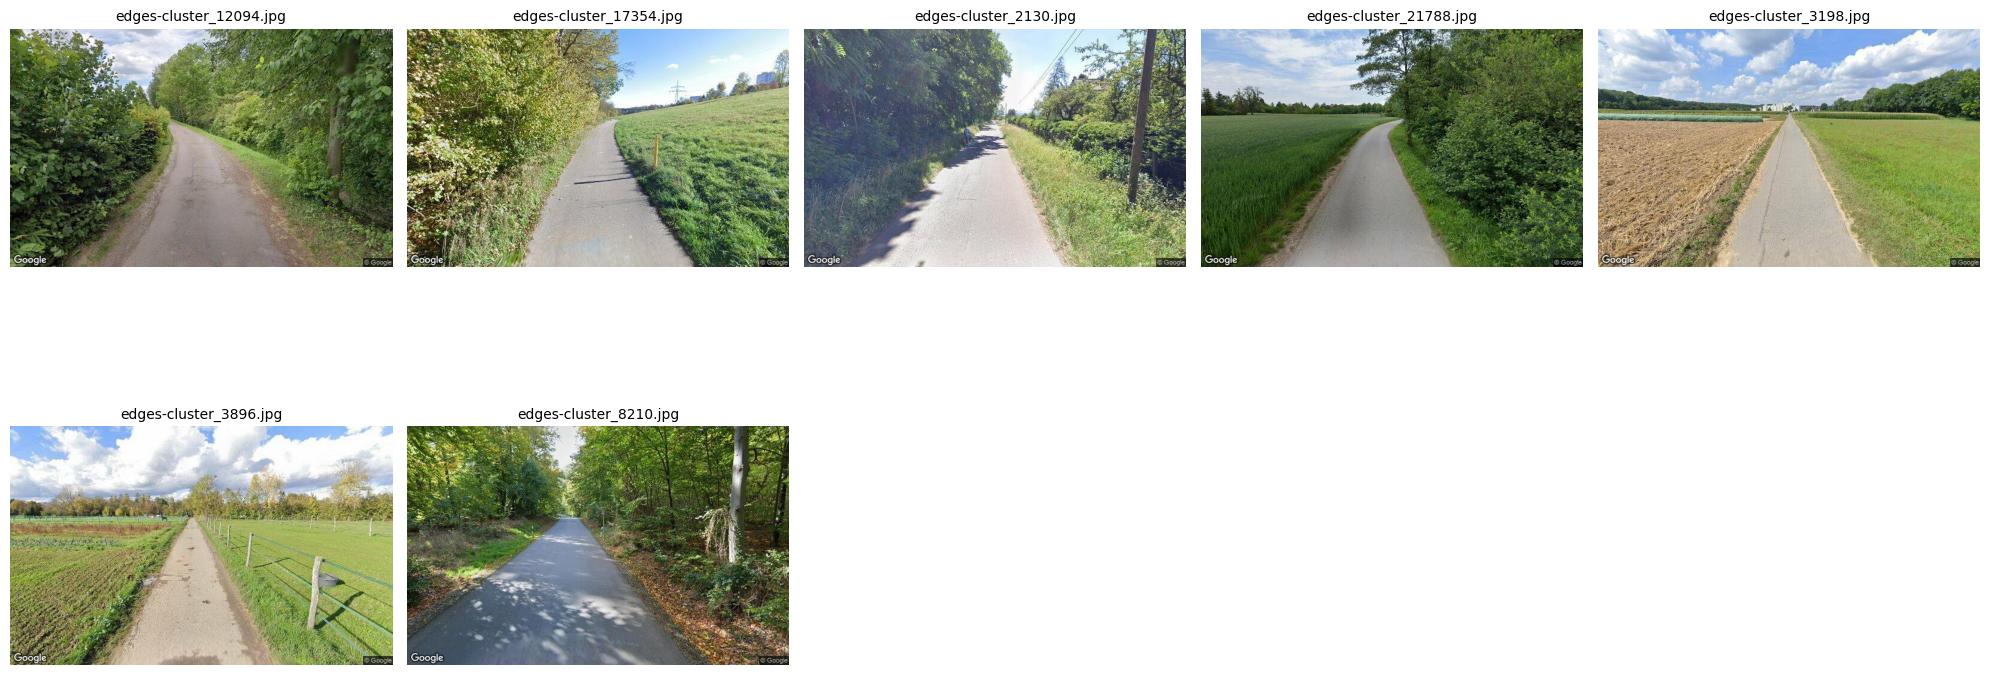

In [72]:
plt.figure(figsize=(20, num_rows * 4))

for i, filename in enumerate(image_filenames, start=1):
    img_path = os.path.join(NEW_DIR, filename)
    image = Image.open(img_path)

    plt.subplot(num_rows, images_per_row, i)
    plt.imshow(image)
    plt.title(filename, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()